<a href="https://colab.research.google.com/github/kssv23/Machine-Learning/blob/main/ML_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔹 Random Forest Accuracy: 0.9980
🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       1.00      1.00      1.00       452
           2       0.99      1.00      1.00       293
           3       1.00      1.00      1.00       185

    accuracy                           1.00      1000
   macro avg       1.00      0.99      1.00      1000
weighted avg       1.00      1.00      1.00      1000

🔹 Confusion Matrix:
 [[ 68   0   2   0]
 [  0 452   0   0]
 [  0   0 293   0]
 [  0   0   0 185]]

🔹 MLP Classifier Accuracy: 0.9830
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93        70
           1       0.99      1.00      0.99       452
           2       0.97      0.98      0.97       293
           3       1.00      1.00      1.00       185

    accuracy                           0.98      1000
   macro avg       0

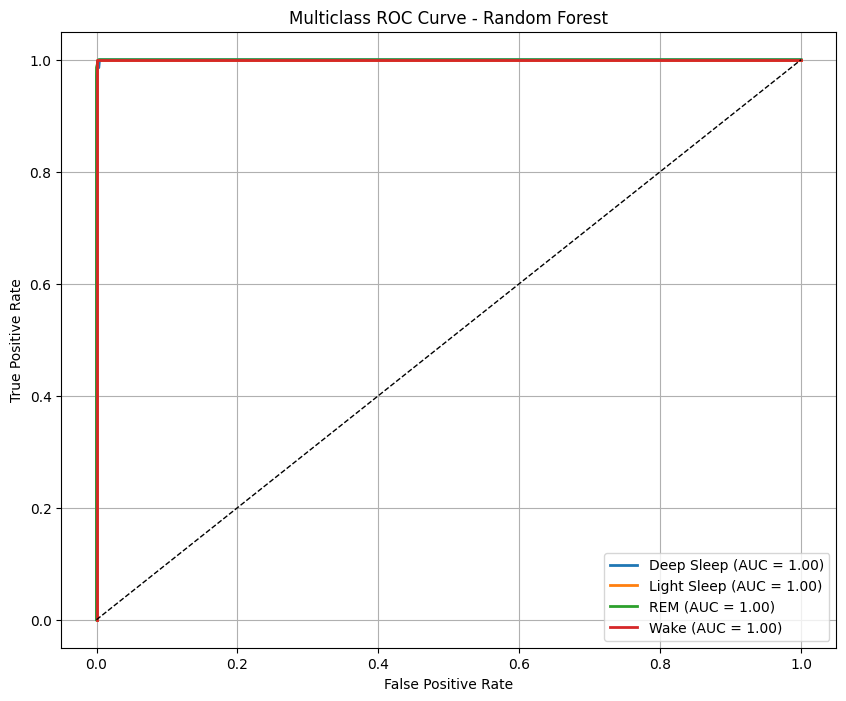

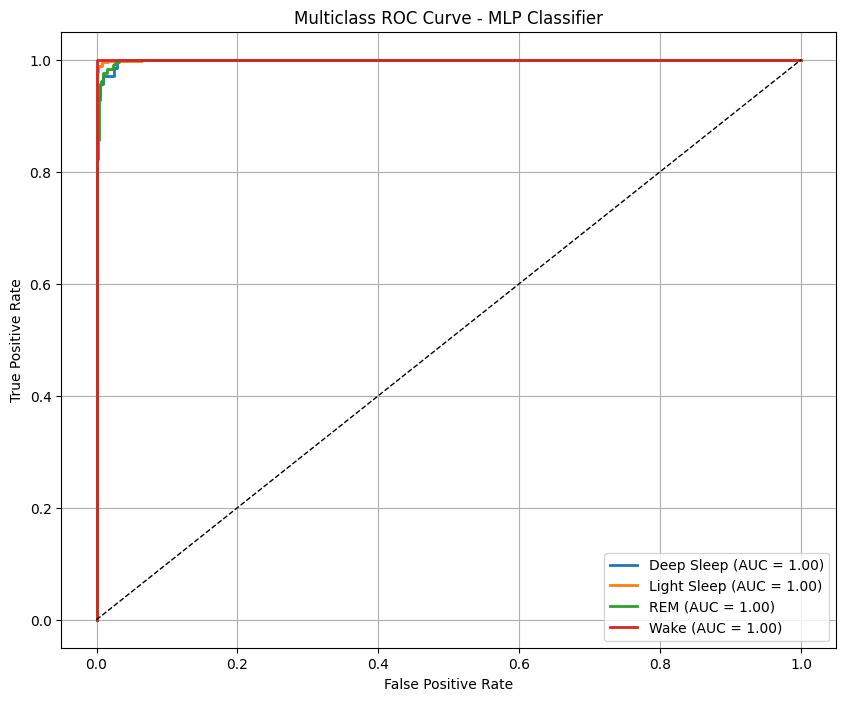

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

file_path = "/content/sleep_cycle_productivity.csv"
df = pd.read_csv(file_path)

df.drop(columns=["Total Sleep Hours.1", "Stress Level.1"], inplace=True)

df = pd.get_dummies(df, columns=["Gender"], drop_first=True)

label_encoder = LabelEncoder()
df["Dominant Sleep Stage Encoded"] = label_encoder.fit_transform(df["Dominant Sleep Stage"])

X = df.drop(columns=["Dominant Sleep Stage", "Dominant Sleep Stage Encoded", "Person_ID"])
y = df["Dominant Sleep Stage Encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include='number'))
X_test_scaled = scaler.transform(X_test.select_dtypes(include='number'))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

rf_model.fit(X_train_scaled, y_train)
mlp_model.fit(X_train_scaled, y_train)

def evaluate_model(model, name):
    y_pred = model.predict(X_test_scaled)
    print(f"\n🔹 {name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("🔹 Classification Report:\n", classification_report(y_test, y_pred))
    print("🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_model(rf_model, "Random Forest")
evaluate_model(mlp_model, "MLP Classifier")

print("\n✅ Cross-Validation Scores (5-fold):")
for model, name in zip([rf_model, mlp_model], ["Random Forest", "MLP"]):
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Save models
os.makedirs('saved_models', exist_ok=True)
joblib.dump(rf_model, '/content/random_forest_model.pkl')
joblib.dump(mlp_model, '/content/mlp_classifier.pkl')
joblib.dump(scaler, '/content/standard_scaler.pkl')
joblib.dump(label_encoder, '/content/label_encoder.pkl')

print("\n💾 Saved files:")
print(os.listdir('saved_models'))

def plot_roc_curves(model, model_name):
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    y_score = model.predict_proba(X_test_scaled)
    class_labels = label_encoder.inverse_transform(np.unique(y))

    plt.figure(figsize=(10, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curves(rf_model, "Random Forest")
plot_roc_curves(mlp_model, "MLP Classifier")
